# Machine Learning for Solving PDEs HW3

In [20]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from math import sqrt
import gc

In [21]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Notes

Under the settings of discrete diffusion, the states at each sites transition sporadically, in the sense that under continuous time modeling, the probability of a state transitioning into a different one undergoes exponential distribution in $t$ before reaching a new state. This poses a different kind of challenge when simulating the process, but also provides unique advantages due to the state space $\chi$ on each site being discrete.

The paper *Score-based continuous-time discrete diffusion models* by Sun et al. introduced two reverse sampling processes, first by a discrete time sampling simulated using Eulerian steps, which requires a marginal distribution $p_t(X_t^d| x_t^{\textbackslash d}; \theta)$ to be learned, while the second utilizes an analytical sampling technique which learns a bridging marginal distribution on $p_{0|t}(x_0^d|x_t^{\textbackslash d};\theta)$.


In our case we will learn the local marginal distribution $p_t(X_t^d| x_t^{\textbackslash d}; \theta)$, due to its backward sampling more closely resembling a natural diffusion process, and potentially lessened dependence on intial sample size.


## Setup

In [3]:
import torch

# Compute Ising Potential

def V_batch(x, J=1.0):
    """
    x: Tensor of shape (B, N), with values in {-1, +1}
    Returns: Tensor of shape (B,), energy of each sample
    """
    # Circularly shift x by -1 to get neighbors
    x_shifted = torch.roll(x, shifts=-1, dims=1)
    energy = -J * torch.sum(x * x_shifted, dim=1)
    return energy


We simulate the process with Glauber dynamics:
1. Pick a site at random
2. $p(x_i = a|x_{-i}) \propto e^{-\Delta V(x)/T}$

In [4]:
import torch

def glauber_sampler(x, energy_fn, itr = 10000, T=1.0):
    """
    Glauber dynamics sampler for discrete Ising model
    x: [B, N] tensor of spins in {-1, +1}, modified in-place
    energy_fn: function that takes [B, N] tensor and returns [B] energies
    steps: number of update steps
    T: temperature
    """
    B, N = x.shape
    for _ in range(itr):
        # Randomly choose spin indices to update for each sample
        flip_indices = torch.randint(0, N, (B,), device=x.device)

        # Compute energy difference
        E_old = energy_fn(x)

        # Propose flipping one spin per batch item
        x[torch.arange(B), flip_indices] *= -1

        E_new = energy_fn(x)
        dE = E_new - E_old

        # Compute flip probabilities using Metropolis rule
        prob = torch.sigmoid(-dE / T)  # equivalent to min(1, exp(-dE/T))

        # Accept/reject proposals
        reject = torch.rand(B, device=x.device) >= prob
        x[torch.arange(B)[reject], flip_indices[reject]] *= -1

    return x


In [5]:
# samples N langevin based samples of dimension d
def sample(N, d, T = 1):
    # Config
    L = 2.5           # domain range
    itr = 100*d       # number of Langevin steps, needs to grow linearly with dimension
    h = 3e-4          # step size

    # Initialize from Uniform[-L, L]^d
    x0 = torch.randint(0, 2, (N, d)) * 2 -1  # shape [B, d]

    # Run simulation
    x_final = glauber_sampler(x0, V_batch, itr=itr, T=T)
    return x_final

In [6]:
X0 = sample(100, 128)
X0.shape

torch.Size([100, 128])

In [7]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_sample(x_np, num_samples=3):
    """
    Visualize a few samples as horizontal line plots across dimensions.

    x_np: [N, D] numpy array
    num_samples: how many samples to show
    """
    D = x_np.shape[1]
    sample_indices = np.random.choice(len(x_np), size=num_samples, replace=False)
    samples = x_np[sample_indices]

    plt.figure(figsize=(10, 4))
    for i, sample in enumerate(samples):
        plt.plot(range(D), sample, marker='o', label=f"sample {i+1}")

    plt.xlabel("Dimension")
    plt.ylabel("Value")
    plt.title(f"{num_samples} Sample Trajectories Across Dimensions")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


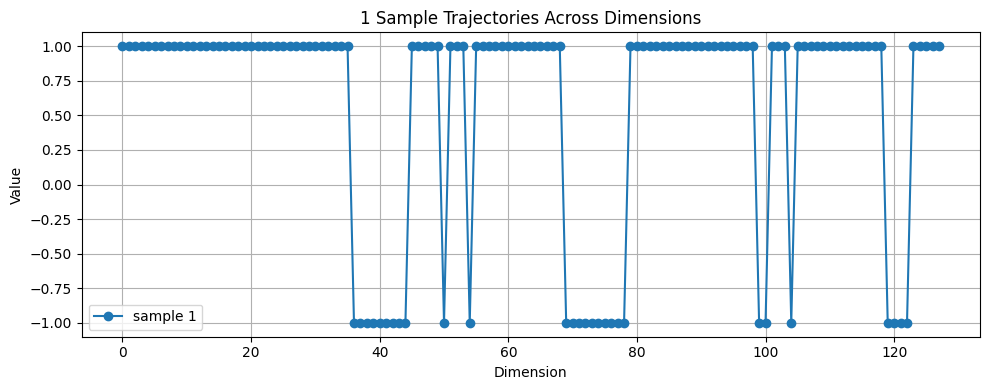

In [8]:
visualize_sample(X0, 1)

# Discrete Diffusion training

## Forward Sampling
We have the following forward diffusion process:
$$\frac{d}{dt} q_{t|s} (x_t|x_s) = \sum_{x\in \chi} q_{t|s} (x|x_s) Q_t(x,x_t),$$
where $Q_t = Q\beta(t)$ is the transition matrix.

Here, we use the uniform stationary base rate, with $n$ the dimension of the sites,
$$Q = \mathbf{1}\mathbf{1}^T - n\mathbb{I} \equiv P \Lambda P^{-1},$$
which can be thought of as a tendency toward a uniform distribution.

We can further check that Q satisfies the l1 preservation rule, namely $\forall q\in \mathbb{R}^n, ||q||_1 = 1$, $||Q q||_1 = 0$.

Explicitly, subtransition matrix in each dimension can be computed as
$$q_{t|s}^d = \left[P \exp\left( \Lambda \int_s^t \beta(\tau) d\tau\right) P^{-1}\right]_d.$$


We let $\beta (\tau) $ be constantly 1, so that $\int_s^t \beta(\tau) d\tau$ is simply $t-s$, and the distribution should become fully uniform at $T= 1$


In [9]:
def diagonalize_Q(d):
    # Step 1: Construct Q in NumPy
    one = np.ones((d, 1))
    Q_np = (one @ one.T) - d*np.eye(d)

    # Step 2: Eigen-decomposition (since Q is symmetric, use eigh)
    eigvals, eigvecs = np.linalg.eigh(Q_np)  # eigvecs @ diag(eigvals) @ eigvecs.T = Q_np

    # Step 3: Convert to PyTorch tensors
    Q = torch.tensor(Q_np, dtype=torch.float64)
    P = torch.tensor(eigvecs, dtype=torch.float64)

    return Q, P, eigvals

def transition(h, P, eigvals):
    return P@torch.diag(torch.tensor(np.exp(eigvals*h)))@(P.T)

In [10]:
Q, P, eigvals =  diagonalize_Q(2)
# P@ Lambda @P.T
transition(0.01, P, eigvals)[:, 0]

tensor([0.9901, 0.0099], dtype=torch.float64)

In [11]:
# diffusion based sampler
def forward_sampler(t1, h, X0, viz=False):
    d = X0.shape[1]
    N = X0.shape[0]
    buffer = []
    ts = []
    # without disturbing the original samples
    X = X0.clone()
    buffer.append(X)
    ts.append(t1)
    # compute a static transition matrix
    Q, P, eigvals =  diagonalize_Q(2)
    tr = transition(h, P, eigvals)
    # for dimension = 2 this degenerates
    # into a single bit flip probability p
    p = tr[0,1]
    while(t1>0):
        t1-=h
        accept = torch.rand((N,d), device=X.device) < p
        X[accept]*=-1
        if(viz and t1//h%500 == 0):
            visualize_sample(X, 1)
        buffer.append(X.clone())
        ts.append(t1)
    return torch.stack(buffer), torch.tensor(ts)

def flatten(layers, ts):
    """
    layers: Tensor of shape (T, N, d)
    ts: Tensor of shape (T,) – time values
    Returns: Tensor of shape (T*N, d+1)
    """
    T, N, d = layers.shape

    # Repeat time values for each sample in a layer
    time_column = ts[:, None].expand(T, N).reshape(-1, 1)  # shape (T*N, 1)

    # Flatten the layer data
    x_flat = layers.reshape(-1, d)  # shape (T*N, d)
    # Concatenate time as the last dimension
    concatenated = torch.cat([x_flat, time_column], dim=1)
    # we take the 1st to last of the time labeled data as x
    # we take the 0th to last-1th of original data as y
    # so that each input maps to the output which is the previous layer's samples
    return concatenated # shape (T*N, d+1)


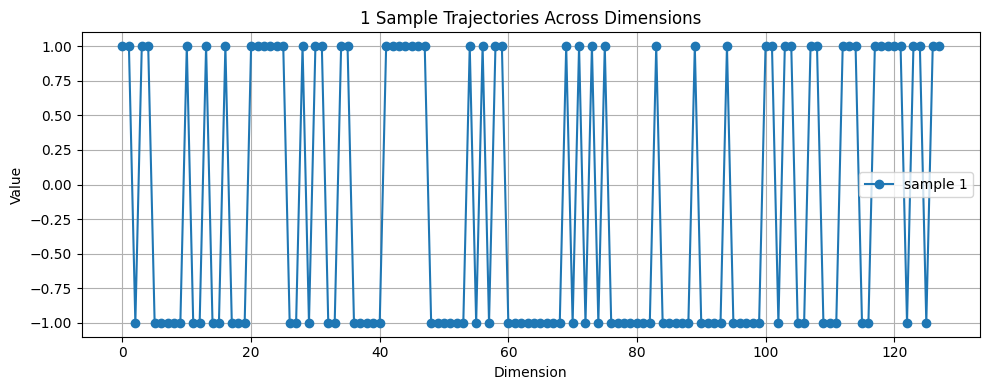

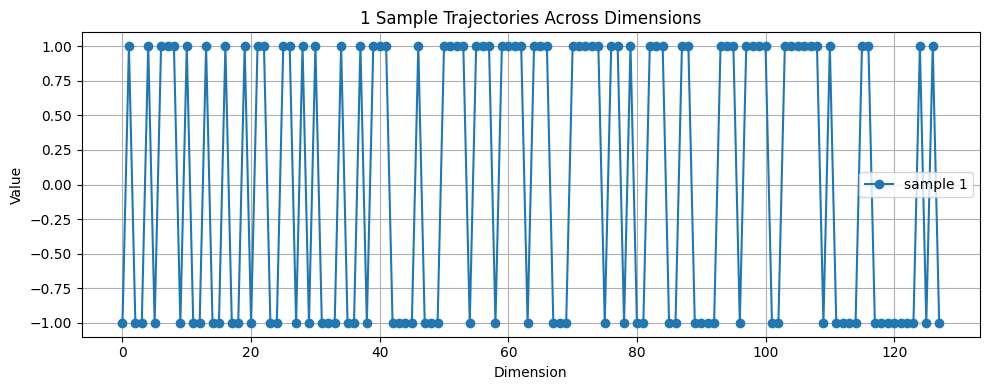

(tensor([[[-1,  1,  1,  ...,  1, -1, -1],
          [ 1,  1,  1,  ...,  1, -1, -1],
          [-1, -1,  1,  ...,  1, -1,  1],
          ...,
          [ 1,  1,  1,  ..., -1,  1,  1],
          [-1,  1,  1,  ...,  1, -1, -1],
          [-1, -1, -1,  ...,  1, -1,  1]],
 
         [[-1, -1, -1,  ..., -1, -1,  1],
          [-1,  1,  1,  ...,  1, -1, -1],
          [-1, -1, -1,  ..., -1, -1, -1],
          ...,
          [ 1,  1,  1,  ..., -1, -1,  1],
          [-1, -1, -1,  ..., -1, -1, -1],
          [ 1,  1,  1,  ..., -1, -1,  1]],
 
         [[-1, -1, -1,  ..., -1, -1,  1],
          [-1,  1,  1,  ...,  1, -1, -1],
          [-1, -1, -1,  ..., -1, -1, -1],
          ...,
          [ 1,  1,  1,  ..., -1, -1,  1],
          [-1, -1, -1,  ..., -1, -1, -1],
          [ 1,  1,  1,  ..., -1, -1,  1]],
 
         ...,
 
         [[-1,  1,  1,  ...,  1, -1, -1],
          [ 1,  1,  1,  ...,  1, -1, -1],
          [-1, -1,  1,  ...,  1, -1,  1],
          ...,
          [ 1,  1,  1,  ..., -1, 

In [12]:
forward_sampler(1, 0.001,X0,True)

## Training Setup

In [13]:
# abstract the procedure of setting up a training into a single function
# h is diffusion time step
def setup_train(N, d, h, t1=1, visualize = False):
    samples = sample(N, d)
    if(visualize):
        visualize_sample(samples.detach().numpy())
    layers, ts = forward_sampler(t1, h, samples)
    if(visualize):
        visualize_sample(layers[-1].detach().numpy())
    xs = flatten(layers, ts)
    return xs, samples

In [14]:
def compute_mean_and_cov(arrays):
    """
    Compute the mean and covariance of a list or array of d-dimensional numpy arrays.

    Parameters:
        arrays (np.ndarray): An (n, d) array, where each row is a d-dimensional sample.

    Returns:
        mean (np.ndarray): A (d,) array representing the mean vector.
        cov (np.ndarray): A (d, d) array representing the covariance matrix.
    """
    arrays = np.asarray(arrays)
    # filter out of range
    # arrays = arrays[np.all((arrays > -2.5) & (arrays < 2.5), axis=1)]
    if arrays.ndim != 2:
        raise ValueError("Input should be a 2D array with shape (n_samples, d)")

    mean = np.mean(arrays, axis=0)
    cov = np.cov(arrays, rowvar=False)  # Each row is a sample

    return mean, cov


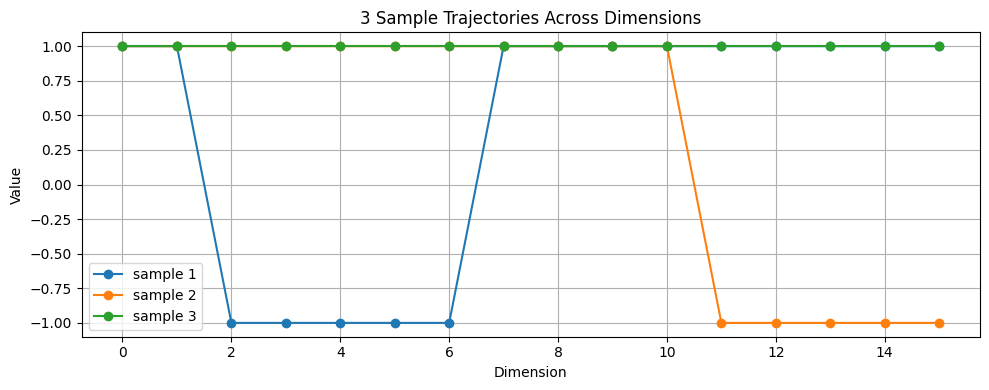

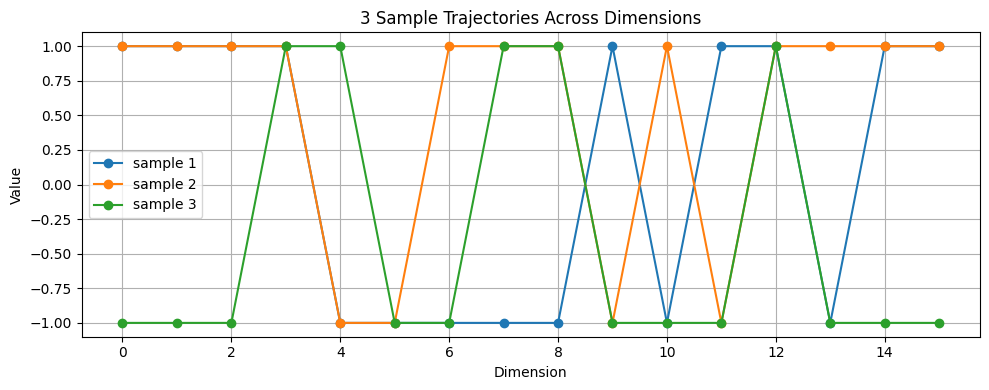

torch.Size([10010000, 17]) torch.Size([10000, 16])


4250

In [15]:
xs, x0 = setup_train(10000, 16, 0.001, t1 = 1, visualize=True)
data_mean, data_cov = compute_mean_and_cov(x0.detach().numpy())
print(xs.shape, x0.shape)
del xs
gc.collect()

## Implementing the network

As we are training a conditional marginal distribution given time $t$,
$$p_t(X^d|x^{\backslash d}; \theta),$$
we will minimize functional
$$\theta^* = \text{argmin}_\theta \int_0^T \sum_{x_t\in \chi^n} q_t(x_t)\sum_{d=1}^D\log p_t(X^d=x_t^d |x_t^{\backslash d} ;\theta)dt.$$

Once we train $p_t(X^d|x^{\backslash d}; \theta)$, we obtain approximation to backward rate
$$R_t^d(x,y) = \frac{q_t(y^d, x^{\backslash d})}{q_t(x^d, x^{\backslash d})} Q_t(y,x) \simeq \frac{p_t(y^d|x^{\backslash d}; \theta)}{p_t(x^d|x^{\backslash d}; \theta)}  Q_t(y,x).$$

Note that for each entry $d$, the network should mask the $d$-th dimension input and take the remaining $\chi^{n-1}$ input along with a new category $y\in \chi$, and output a probability.

For the binary state space, we may simplify the interface from $[n]\times \chi^{n-1} \times \chi \times \mathbb{R}\rightarrow \mathbb{R}$ to $$N:\chi^n\times \mathbb{R} \rightarrow \mathbb{R}^{n},$$
where we implicitly mask the $d$-th input dimension from the conditional marginal for the $d$-th output dimension, and the output probability corresponds to the $+1$ case.

Namely:
$$p_t(X^d = +1 | x^{\backslash d}) = N(x, t)[d];$$

$$p_t(X^d = -1 | x^{\backslash d}) = 1-N(x, t)[d].$$

However, due to translational invariance (of the potential), we may simplify the network with the underlying structure of $N$ given by $$N(x,t)[d] = M(x^{\backslash d}[rotated],t).$$.

In [31]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# we use a simple linear network to modulate the time dependence
class FiLM(nn.Module):
    def __init__(self, channels, t_dim=1, hidden_dim=16):
        super().__init__()
        self.film = nn.Sequential(
            nn.Linear(t_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, channels * 2)  # gamma and beta
        )
        self.channels = channels

    def forward(self, x, t):
        """
        x: [batch, channels, spatial_dim]
        t: [batch, t_dim]
        """
        params = self.film(t)           # [batch, 2*channels]
        gamma, beta = params.chunk(2, dim=-1)  # Each: [batch, channels]
        gamma = gamma.unsqueeze(-1)     # [batch, channels, 1]
        beta = beta.unsqueeze(-1)       # [batch, channels, 1]
        return gamma * x + beta

class RotConvFiLMNetM(nn.Module):
    def __init__(self, n_minus_1, conv_channels=6, kernel_size=3, hidden_dim=32, t_dim=1):
        super().__init__()
        self.n_minus_1 = n_minus_1
        # use convolution on the input
        self.conv = nn.Conv1d(
            in_channels=1,
            out_channels=conv_channels,
            kernel_size=kernel_size,
            padding=kernel_size // 2,
            padding_mode='circular'
        )
        self.conv2 = nn.Conv1d(
            in_channels=conv_channels,
            out_channels=1,
            kernel_size=kernel_size,
            padding=kernel_size // 2,
            padding_mode='circular'
        )

        self.film = FiLM(conv_channels, t_dim, hidden_dim)
        self.fc = nn.Sequential(
            nn.Linear(n_minus_1, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1),
            nn.Sigmoid()
        )

    def forward(self, x_spatial, t):
        """
        x_spatial: [batch, n-1], entries in {-1, 1}
        t: [batch, 1], float
        """
        x = x_spatial.unsqueeze(1)        # [batch, 1, n-1]

        conv_out = self.conv(x)           # [batch, conv_channels, n-1]
        conv_out = self.film(conv_out, t) # Modulate by time!
        conv_out = F.silu(conv_out)       # add in non-linearity
        conv_out = self.conv2(conv_out)[:,0,:]    # [batch, conv_chanels, n-1] -> [batch, n-1]
        out = self.fc(conv_out)             # [batch, 1], in (0,1)
        return out.squeeze(-1)            # [batch]


class MaskedWrapperN(nn.Module):
    """
    Wraps a module M(x_masked, t) -> scalar
    to apply it to all sites in x.
    """
    def __init__(self, d):
        super().__init__()
        self.M =  RotConvFiLMNetM(d-1) # Any nn.Module: takes (x_masked, t) and returns [batch] or [batch,1]


    def forward(self, xt):
        x = xt[:, :-1]
        t = xt[:, -1].unsqueeze(1)
        """
        x: [batch, n], entries in {-1,1}
        t: [batch, 1]
        Output: [batch, n], N(x, t)[d] = M(x^{\backslash d}, t)
        """
        batch, n = x.shape
        outputs = []
        for d in range(n):
            # Roll so that the entry d%n is now at index 0
            x_rolled = torch.roll(x, shifts= -(d%n), dims=1)  # [batch, n]
            # print(x_rolled[:,0]-x[:,d])
            # Remove the first entry, so we get [x_{d+2}, ..., x_{d}, ...]
            x_masked = x_rolled[:, 1:]   # [batch, n-1]
            x_masked = x_masked / n      # (optional normalization)
            y_d = self.M(x_masked, t)    # [batch]
            outputs.append(y_d.unsqueeze(1))
        out = torch.cat(outputs, dim=1)
        return out



The loss simplifies into for sample space $S \subset \chi^n \times T$
$$\begin{align*}\theta^* &= \text{argmin}_\theta \int_0^T \sum_{x_t\in \chi^n} q_t(x_t)\sum_{d=1}^D-\log p_t(X^d=x_t^d |x_t^{\backslash d} ;\theta)dt\\
&= \text{argmin}_\theta \sum_{x_t\in S}\sum_{d=1}^D-\log p_t(X^d=x_t^d |x_t^{\backslash d} ;\theta)\\
&=\text{argmin}_\theta \sum_{x_t\in S}\sum_{d=1}^D-\log\left(\frac{1}{2}-\frac{1}{2} x_t^d +x_t^d N(x,t)[d]\right)\\
&=\text{argmin}_\theta \sum_{x_t\in S}\text{sum}\left(-\log\left(\frac{1}{2}-\frac{1}{2} x_t +x_t* N(x,t)\right), \text{axis} = -1\right)
\end{align*}
$$

In [17]:
# compute loss on scores
def compute_loss(xs, model):
    n = xs.shape[0]
    d = xs.shape[1] - 1
    ns = model(xs)
    # print(0.5+xs[:,:-1]*(ns-0.5))
    # print("train: ", xs[5,:-1])
    # print("out: ", ns[5,:-1])
    # print("error: ", 0.5+xs[:,:-1]*(ns-0.5))
    # normalize error by dimension for consistency
    return -torch.log(0.5+xs[:,:-1]*(ns-0.5)).sum()/d/n

def train(N, d, h, t1 = 1, B = 100, model=None, epsilon=1e-4, max_steps=10000):
    xs, x0 = setup_train(N, d, h, t1 = t1)
    if(model == None):
        model = MaskedWrapperN(d)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    for step in range(max_steps):
        idx = torch.randint(0, xs.shape[0], (B,))
        batch = xs[idx]
        loss = compute_loss(batch, model)
        optimizer.zero_grad()
        loss.backward()

        if(step%(min(max_steps//10, 100))==0):
            # Compute total gradient norm
            grad_norm = 0.0
            for p in model.parameters():
                if p.grad is not None:
                    grad_norm += p.grad.norm().item()**2
            grad_norm = grad_norm**0.5

            # Check termination condition
            if grad_norm < epsilon or loss<-4:
                print(f"Stopping early at step {step}, grad norm {grad_norm:.2e}")
                break

            print(f'training {step} step with loss {loss}')
        optimizer.step()

    return model, xs

In [ ]:
masked_p, xs = train(1000, 16, 0.005, t1 = 1, B  = 100, max_steps = 5000)

training 0 step with loss 0.6993951201438904
training 100 step with loss 0.6930335760116577
training 200 step with loss 0.6886628866195679
training 300 step with loss 0.6554592847824097
training 400 step with loss 0.6353268623352051
training 500 step with loss 0.6430647969245911
training 600 step with loss 0.6202414035797119
training 700 step with loss 0.6317144632339478
training 800 step with loss 0.6125868558883667
training 900 step with loss 0.6374459266662598
training 1000 step with loss 0.6229844689369202
training 1100 step with loss 0.6295598745346069
training 1200 step with loss 0.613991379737854
training 1300 step with loss 0.6158667206764221
training 1400 step with loss 0.6371795535087585
training 1500 step with loss 0.6429629325866699
training 1600 step with loss 0.6274345517158508
training 1700 step with loss 0.6409488916397095
training 1800 step with loss 0.6264355182647705
training 1900 step with loss 0.6353839039802551
training 2000 step with loss 0.6245768070220947
train

In [ ]:
masked_p(xs[[0,90,1000,5020,30],:])


tensor([[0.3820, 0.3820, 0.4694, 0.4694, 0.3891, 0.4761, 0.3895, 0.4761, 0.3895,
         0.4761, 0.3895, 0.4761, 0.3891, 0.4698, 0.4698, 0.4698],
        [0.3996, 0.3174, 0.3957, 0.3141, 0.3141, 0.3141, 0.3924, 0.3924, 0.3924,
         0.3167, 0.3924, 0.3924, 0.3924, 0.3924, 0.3924, 0.3171],
        [0.8387, 0.8387, 0.8802, 0.8802, 0.8387, 0.8387, 0.8387, 0.8387, 0.8387,
         0.8387, 0.8387, 0.8387, 0.8387, 0.8387, 0.8387, 0.8387],
        [0.5981, 0.5981, 0.6534, 0.6534, 0.6534, 0.6534, 0.6001, 0.6553, 0.5981,
         0.5981, 0.5981, 0.6526, 0.5981, 0.5981, 0.5981, 0.5981],
        [0.3174, 0.4000, 0.4000, 0.4000, 0.4000, 0.4000, 0.3236, 0.3996, 0.3996,
         0.3210, 0.3210, 0.3210, 0.4000, 0.4000, 0.4000, 0.3174]],
       grad_fn=<CatBackward0>)

During inverse diffusion, we make the following computations:
$$p_{t+\epsilon|t}^d(X_{t+\epsilon}^d = c\,|\, x_t^{\backslash d}; \theta) =
\begin{cases}
    \epsilon\, R_t^d\left(x_t,\, x_{t+\epsilon}^d = c;\, \theta\right) & \text{if } c \neq x_t^d \\
    1-\epsilon\, R_t^d\left(x_t,\, x_{t+\epsilon}^d = -c;\, \theta\right) & \text{otherwise}
\end{cases}$$

In [ ]:
# Eulerian Backward Diffusion Sampler (Fully Vectorized, Batches All Dimensions)
import torch

def stable_diffusion(masked_prbs, d, N, h, t1, device=None):
    """
    masked_prbs: function mapping (N x (d+1)) input to (N x d) probabilities
    d: dimension
    N: batch size
    h: time step
    t1: total time
    device: torch device
    mean: mean for output shift (default 0)
    """
    if device is None:
        device = torch.device('cpu')

    t = 0.0
    y0 = torch.randint(0, 2, (N, d), device=device, dtype=torch.float32)
    y = (y0 * 2 - 1)

    Q, P, eigvals = diagonalize_Q(2)
    Q_off_diag = float(Q[0, 1])  # flip rate

    while t <= t1 + 1e-6:
        x = torch.cat((y, torch.full((N, 1), t, dtype=y.dtype, device=device)), dim=1)
        ns = masked_prbs(x)  # (N x d), probability of +1 for each bit

        p_plus = ns
        p_minus = 1 - ns
        curr_val = y

        # For each entry, p_flip = p_plus if y == -1 else p_minus
        p_flip = torch.where(curr_val == 1, p_minus, p_plus)
        p_stay = torch.where(curr_val == 1, p_plus, p_minus)

        R = Q_off_diag * p_flip / (p_stay + 1e-12)
        flip_prob = h * R
        flip_prob = torch.clamp(flip_prob, 0, 1)

        flip = torch.rand(N, d, device=device) < flip_prob
        y[flip] *= -1

        t += h
    return y


In [ ]:
ys = stable_diffusion(masked_p, 16, 10000, 0.01, 1)
ys = ys.detach().numpy()

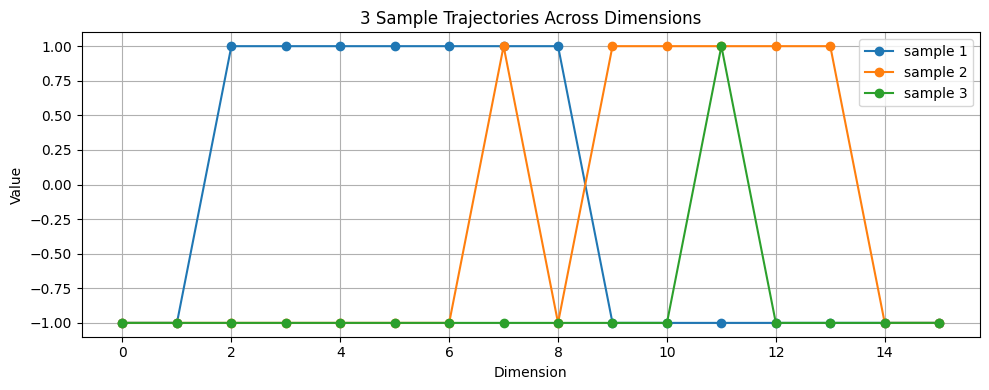

In [ ]:
visualize_sample(ys,3)

It seems for some of the samples, the distribution looks quite convincing.

We will proceed to comparing the covariance and mean:

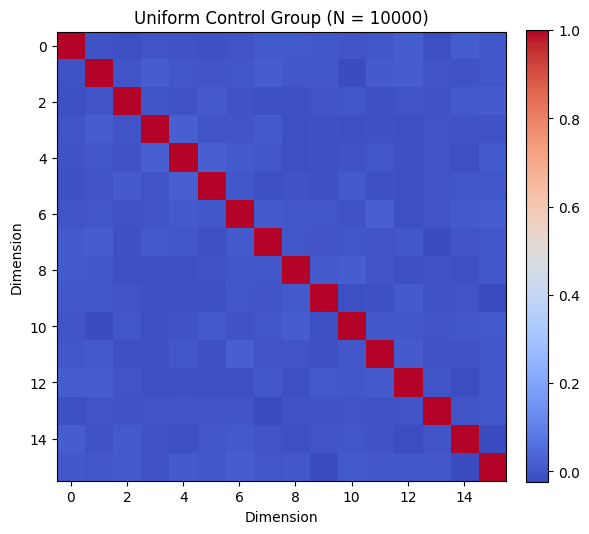

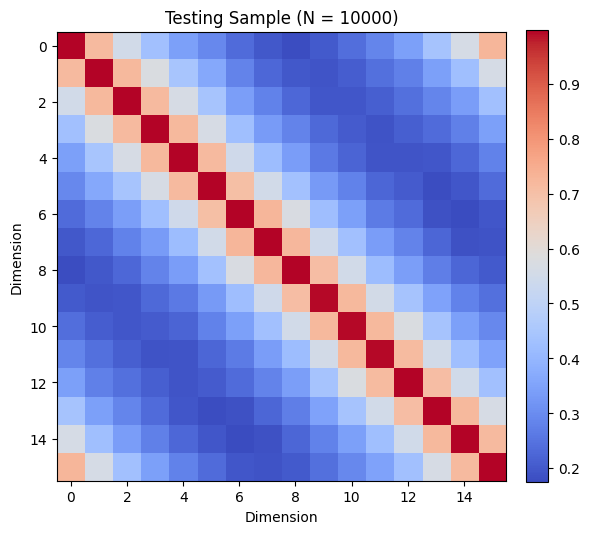

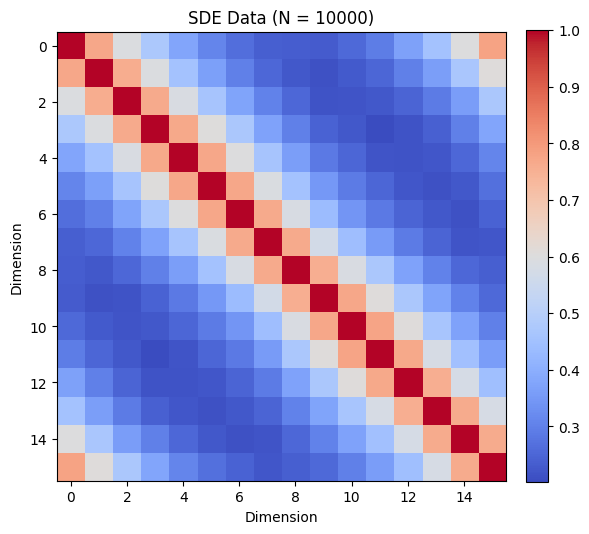

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_cov_matrix(cov, ax=None, labels=None, title="Covariance Matrix"):
    """
    Plot a covariance matrix as a heatmap.

    Parameters:
        cov (np.ndarray): (d, d) covariance matrix.
        ax (matplotlib.axes.Axes, optional): Axis to plot on.
        labels (list, optional): List of d labels for axis ticks.
        title (str): Title of the plot.
    """
    if ax is None:
        fig, ax = plt.subplots(figsize=(6,6))
    im = ax.imshow(cov, cmap='coolwarm', interpolation='nearest')
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    d = cov.shape[0]
    if labels is not None:
        ax.set_xticks(np.arange(d))
        ax.set_yticks(np.arange(d))
        ax.set_xticklabels(labels)
        ax.set_yticklabels(labels)
    ax.set_title(title)
    ax.set_xlabel("Dimension")
    ax.set_ylabel("Dimension")
    plt.tight_layout()
    plt.show()

mean_uniform, cov_uniform = compute_mean_and_cov(2 * np.random.randint(0, 2, size=(10000,16)) - 1)
plot_cov_matrix(cov_uniform, title='Uniform Control Group (N = 10000)')

mean_trained, cov_trained = compute_mean_and_cov(ys)
plot_cov_matrix(cov_trained, title='Testing Sample (N = 10000)')

mean_data, cov_data = compute_mean_and_cov(x0)
plot_cov_matrix(cov_data, title='SDE Data (N = 10000)')


In [ ]:
print(f"Trained mean: {mean_trained}")
# print(f"Trained covariance: {cov_trained}")
print(f"Data mean: {mean_data}")
# print(f"Data covariance: {cov_data}")
print(f"Mean Error: {np.linalg.norm(mean_trained)}")
print(f"Covariance Error: {np.linalg.norm(cov_trained - cov_data)}")
print(f"Uniform Covariance Error: {np.linalg.norm(cov_uniform - cov_data)}")

Trained mean: [0.0654 0.0668 0.059  0.0488 0.061  0.0728 0.0742 0.068  0.0746 0.0792
 0.0774 0.075  0.0736 0.0688 0.0548 0.0704]
Data mean: [ 0.0052  0.0108  0.004   0.001   0.004   0.0006  0.005   0.0056  0.0082
  0.0218  0.0208  0.0154  0.0204  0.0122  0.0042 -0.0028]
Mean Error: 0.2744366526603699
Covariance Error: 0.487388104978924
Uniform Covariance Error: 6.935428244571773


As we may observe, the network with two convolution layers modulated by a FiLM layer in between, then passed into a fully connected layer was capable of learning the distribution on a sample size of 1000 with diffusion step size 0.05. **The convariance error between the training and testing data was 0.487, compared to the covariance error between a uniformly generated random sample and the training data which is as high as 6.954. The mean error was also close to 0.**  We expect to see a further decrease in error with training sample size increased to near 10000.

We shall continue to constructing the experiment for $(N,d)\in\{20^2, 40^2, 60^2, 80^2, 100^2\}\times \{16,32,64,128\}$ for a more thorough comparison.

## (a)
Compare the sample mean and covariance obtained from the score based di usion model with
 those from the SDE simulation. Use di erent values of N. Do you see the error decay as $\frac{1}{\sqrt{N}}$?

In [22]:

# GPU Ready:
def train_gpu(N, d, h, t1 = 1, B = 100, model=None, epsilon=1e-4, max_steps=10000):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    xs, x0 = setup_train(N, d, h, t1 = t1)
    xs = xs.to(device)
    x0 = x0.to(device) # Move x0 to GPU if needed later

    if model is None:
        model = MaskedWrapperN(d).to(device)
    else:
        model = model.to(device) # Move existing model to GPU

    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    for step in range(max_steps):
        idx = torch.randint(0, xs.shape[0], (B,), device=device)
        batch = xs[idx]
        loss = compute_loss(batch, model)

        optimizer.zero_grad()
        loss.backward()

        if(step%(min(max_steps//10, 100))==0):
            # Compute total gradient norm
            grad_norm = 0.0
            for p in model.parameters():
                if p.grad is not None:
                    grad_norm += p.grad.norm().item()**2
            grad_norm = grad_norm**0.5

            # Check termination condition
            # Move loss to CPU for printing/comparison if on GPU
            current_loss = loss.item()
            if grad_norm < epsilon or current_loss < -4:
                print(f"Stopping early at step {step}, grad norm {grad_norm:.2e}")
                break

            print(f'training {step} step with loss {current_loss}')
        optimizer.step()

    # Move model back to CPU if desired after training, or keep on GPU for inference
    # model = model.to('cpu')
    # xs = xs.to('cpu')
    # x0 = x0.to('cpu')

    return model, xs


In [23]:
# GPU Ready:

def stable_diffusion_gpu(masked_prbs, d, N, h, t1, device=None):
    """
    Eulerian Backward Diffusion Sampler (Fully Vectorized, Batches All Dimensions)
    GPU Ready version.

    masked_prbs: function mapping (N x (d+1)) input to (N x d) probabilities.
                 Should be a torch.nn.Module that runs on the specified device.
    d: dimension
    N: batch size
    h: time step
    t1: total time
    device: torch device (e.g., 'cuda', 'cpu')
    """
    if device is None:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Move the model to the specified device
    # Assuming masked_prbs is a torch.nn.Module
    masked_prbs.to(device)

    t = 0.0
    # Initialize on the specified device
    y0 = torch.randint(0, 2, (N, d), device=device, dtype=torch.float32)
    y = (y0 * 2 - 1)

    # diagonalize_Q returns numpy arrays, convert to torch tensors on device
    Q_np, P_np, eigvals_np = diagonalize_Q(2)
    Q = torch.tensor(Q_np, dtype=torch.float64, device=device)
    # P and eigvals are not directly used in the loop, only Q_off_diag
    Q_off_diag = float(Q[0, 1])  # flip rate

    # Convert Q_off_diag back to tensor if needed in calculations, but float is fine here

    while t <= t1 + 1e-6:
        # Ensure all tensors used in the forward pass are on the same device
        x = torch.cat((y, torch.full((N, 1), t, dtype=y.dtype, device=device)), dim=1)

        # Call the masked_prbs model
        with torch.no_grad(): # Inference mode for sampling
            ns = masked_prbs(x)  # (N x d), probability of +1 for each bit

        p_plus = ns
        p_minus = 1 - ns
        curr_val = y

        # For each entry, p_flip = p_plus if y == -1 else p_minus
        p_flip = torch.where(curr_val == 1, p_minus, p_plus)
        p_stay = torch.where(curr_val == 1, p_plus, p_minus)

        # Ensure Q_off_diag is a tensor on device for calculation
        R = torch.tensor(Q_off_diag, device=device) * p_flip / (p_stay + 1e-12)
        flip_prob = h * R
        flip_prob = torch.clamp(flip_prob, 0, 1)

        # Generate random numbers on the same device
        flip = torch.rand(N, d, device=device) < flip_prob
        y[flip] *= -1

        t += h

    return y


In [40]:
# prompt: please simplify the run experiment for d logic by reusing previously defined train_gpu

import gc # Import the garbage collection module

def run_experiment_for_d(d, N_values, h = 0.005, inf_h = 0.01, t1=1, use_trained = False, max_steps_per_logN=1000):
    """
    Runs experiment (a) comparing sample mean and covariance for different N values.

    Args:
        N_values (list): List of N values to test.
        d (int): Dimension of the samples.
        h (float): Diffusion step size.
        t1 (float): Final diffusion time.
        max_steps_per_N (int): Maximum training steps for each N value.
    """
    mean_errors = []
    cov_errors = []

    # Generate initial data for comparison outside the loop for efficiency
    # Assuming the target distribution doesn't change with N, only sample size does
    # We need a large reference set to compare against
    x0 = sample(100000, d)
    data_mean_ref, data_cov_ref = compute_mean_and_cov(x0.detach().numpy())
    del x0
    print("Reference data generated.")

    for N in N_values:
        print(f"\n--- Running experiment for N = {N}, d = {d} ---")

        # Reuse the train_gpu function
        # We will re-initialize the model and optimizer for each N unless specified otherwise
        masked_p = MaskedWrapperN(d)
        optimizer = None # Let train_gpu create a new optimizer
        # Adjust max_steps based on N if needed, or keep constant
        current_max_steps = int(max_steps_per_logN*np.log10(N)) # Could scale with log(N) or sqrt(N)
        model = masked_p
        if(use_trained):
          masked_p.load_state_dict(torch.load(f'masked_p{d}_{N}.pth',map_location=torch.device('cpu')))
          # run this step to restore initial mean and variance estimations
        else:
          # train for two epochs
          # first pretrain on small batches
            # train(1000, 16, 0.005, t1 = 1, B  = 100, max_steps = 5000)
          model, xs = train_gpu(
              N, d, h, t1=t1,
              model=masked_p,
              B= N//10,
              max_steps=current_max_steps
          )
          del xs
        torch.cuda.empty_cache()
        gc.collect()

        torch.save(masked_p.state_dict(), f'masked_p{d}_{N}.pth')

        print(f"Training finished for N = {N}.")

        # Generate samples from the trained model
        N_generate = 10000 # Generate a fixed large number of samples for consistent evaluation
        print(f"Generating {N_generate} samples from the trained model for N = {N}.")
        ys_batches = []
        batch_size_inf = 10000 # Smaller batch size for inference if memory is an issue

        # batch compute samples
        for i in range(N_generate // batch_size_inf):

          ys = stable_diffusion(
              model,
              d=d,
              N=batch_size_inf,
              h=inf_h, # Inference step size can be different from training h
              t1=t1
          )
          ys_cpu = ys.cpu().detach().numpy()
          ys_batches.append(ys_cpu)

          del ys

          # make sure that there is enough memory in GPU
          torch.cuda.empty_cache()
          gc.collect()

        print(f"Sample generation finished for N = {N}.")
        ys_all = np.concatenate(ys_batches, axis=0)
        print(f"Concatenation finished for N = {N}.")

        # Compute mean and covariance of the generated samples
        trained_mean, trained_cov = compute_mean_and_cov(ys_all)

        del ys_all
        torch.cuda.empty_cache()
        gc.collect()

        # Compute errors relative to the reference data
        mean_error = np.linalg.norm(trained_mean - data_mean_ref)
        cov_error = np.linalg.norm(trained_cov - data_cov_ref) # Frobenius norm

        mean_errors.append(mean_error)
        cov_errors.append(cov_error)

        print(f"N = {N}: Mean Error = {mean_error:.4e}, Covariance Error = {cov_error:.4e}")

    return mean_errors, cov_errors, N_values


In [25]:
def plot_errors(N_values, mean_errors, cov_errors, d_val):
    """Plots mean and covariance errors against N on regular and log-log scales."""
    N_values_np = np.array(N_values)
    mean_errors_np = np.array(mean_errors)
    cov_errors_np = np.array(cov_errors)

    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    # Regular plot
    axes[0].plot(N_values_np, mean_errors_np, marker='o', label='Mean Error')
    axes[0].plot(N_values_np, cov_errors_np, marker='x', label='Covariance Error')
    axes[0].set_xlabel('Sample Size (N)')
    axes[0].set_ylabel('Error (Frobenius Norm)')
    axes[0].set_title(f'Error vs. Sample Size (d={d_val}) - Regular Scale')
    axes[0].legend()
    axes[0].grid(True)

    # Log-log plot
    axes[1].loglog(N_values_np, mean_errors_np, marker='o', label='Mean Error')
    axes[1].loglog(N_values_np, cov_errors_np, marker='x', label='Covariance Error')
    # Add theoretical O(1/sqrt(N)) decay line
    # Choose a reference point and plot decay relative to it
    if len(N_values) > 1:
      N_ref = N_values_np[1]
      mean_err_ref = mean_errors_np[1]
      cov_err_ref = cov_errors_np[1]
      axes[1].loglog(N_values_np, mean_err_ref * np.sqrt(N_ref / N_values_np), linestyle='--', color='gray', label=r'$O(1/\sqrt{N})$ (Mean Ref)')
      axes[1].loglog(N_values_np, cov_err_ref * np.sqrt(N_ref / N_values_np), linestyle=':', color='purple', label=r'$O(1/\sqrt{N})$ (Cov Ref)')

    axes[1].set_xlabel('Sample Size (N)')
    axes[1].set_ylabel('Error (Frobenius Norm)')
    axes[1].set_title(f'Error vs. Sample Size (d={d_val}) - Log-Log Scale')
    axes[1].legend()
    axes[1].grid(True, which="both", ls="-")

    plt.tight_layout()
    plt.show()






In [41]:
# Define experiment parameters
N_values = [400, 1600, 3600, 6400, 10000]
# d_values = [16, 32, 64, 128]

# Run experiments for each d
# test first
# mean_errors_16, cov_errors_16, N_experiment_16 = run_experiment_for_d(16, N_values,max_steps_per_logN=1500, use_trained = True)
# %store mean_errors_16
# %store cov_errors_16
# %store N_experiment_16

mean_errors_32, cov_errors_32, N_experiment_32 = run_experiment_for_d(32, N_values,max_steps_per_logN=1500, use_trained = True)
%store mean_errors_32
%store cov_errors_32
%store N_experiment_32

mean_errors_64, cov_errors_64, N_experiment_64 = run_experiment_for_d(64, N_values,max_steps_per_logN=1500, use_trained = True)
%store mean_errors_64
%store cov_errors_64
%store N_experiment_64

mean_errors_128, cov_errors_128, N_experiment_128 = run_experiment_for_d(128, N_values,max_steps_per_logN=1500)
%store mean_errors_128
%store cov_errors_128
%store N_experiment_128


Reference data generated.

--- Running experiment for N = 400, d = 32 ---
Training finished for N = 400.
Generating 10000 samples from the trained model for N = 400.
Sample generation finished for N = 400.
Concatenation finished for N = 400.
N = 400: Mean Error = 5.5784e-01, Covariance Error = 1.6084e+00

--- Running experiment for N = 1600, d = 32 ---
Training finished for N = 1600.
Generating 10000 samples from the trained model for N = 1600.
Sample generation finished for N = 1600.
Concatenation finished for N = 1600.
N = 1600: Mean Error = 1.2912e+00, Covariance Error = 1.3203e+00

--- Running experiment for N = 3600, d = 32 ---
Training finished for N = 3600.
Generating 10000 samples from the trained model for N = 3600.
Sample generation finished for N = 3600.
Concatenation finished for N = 3600.
N = 3600: Mean Error = 1.6681e-01, Covariance Error = 1.1771e+00

--- Running experiment for N = 6400, d = 32 ---
Training finished for N = 6400.
Generating 10000 samples from the trained

KeyboardInterrupt: 

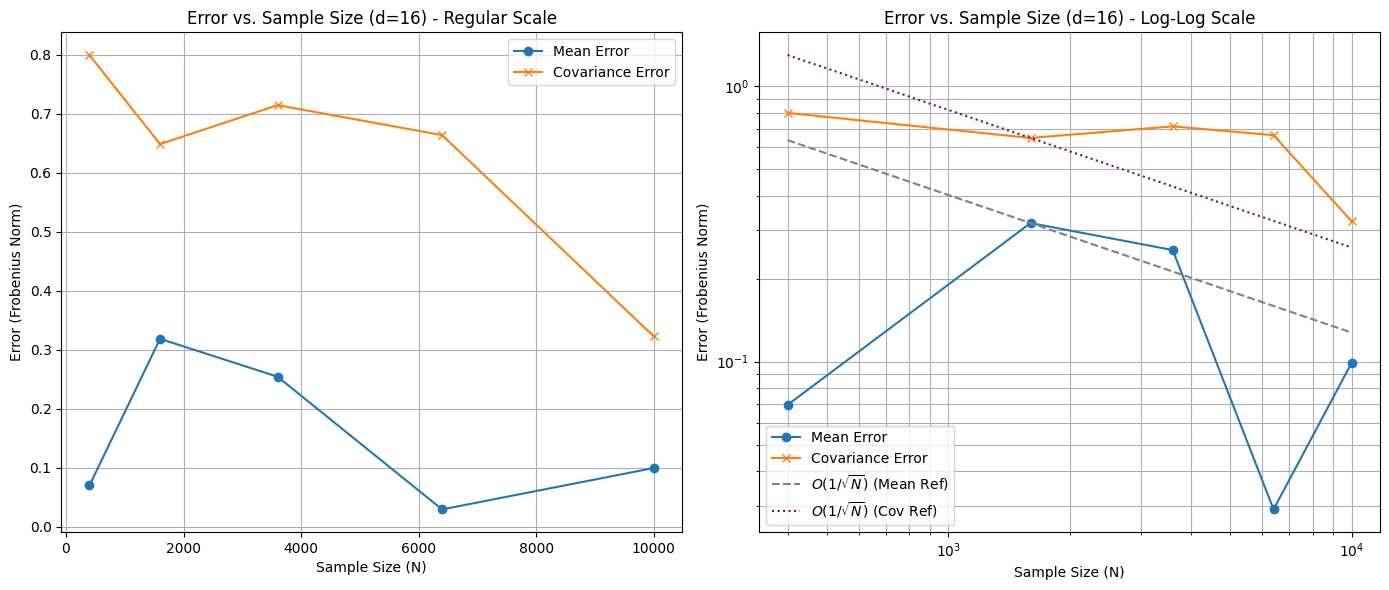

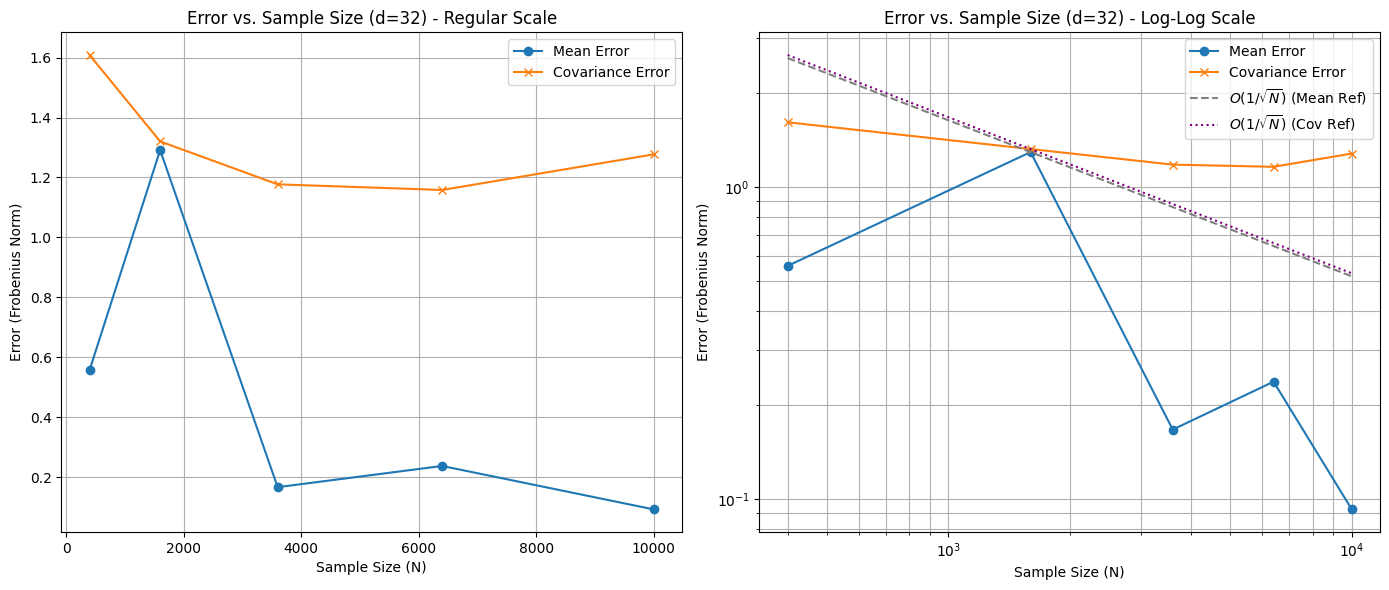

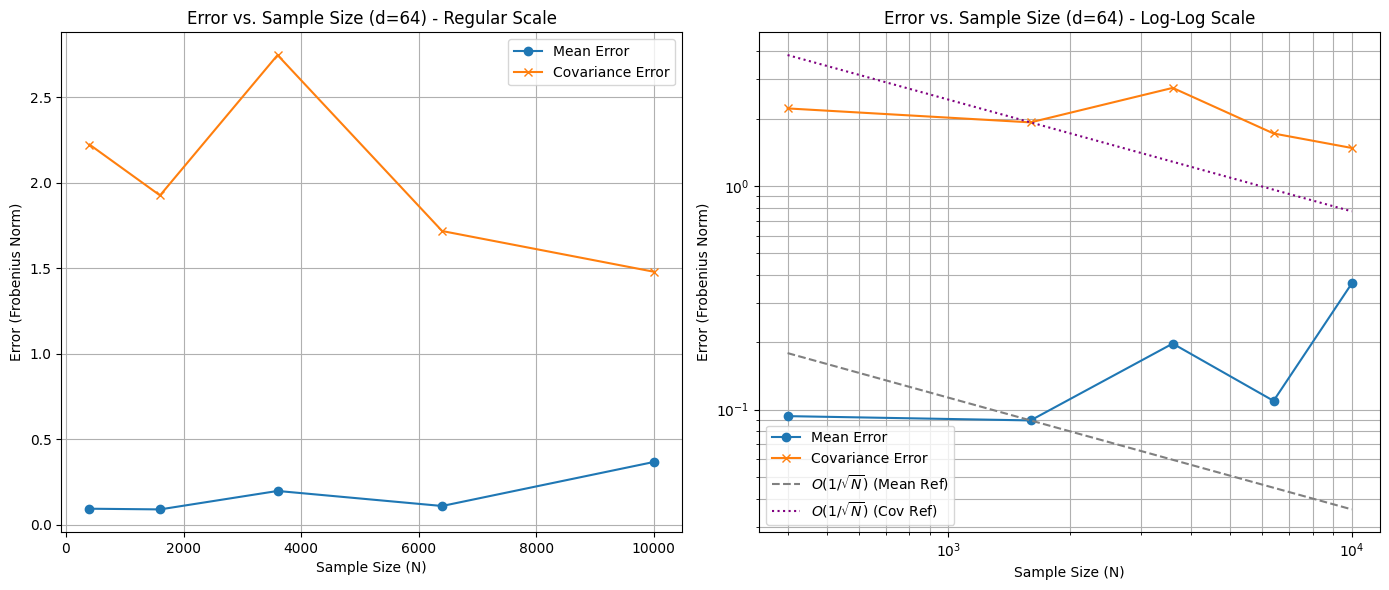

NameError: name 'N_experiment_128' is not defined

In [42]:
# plot data
plot_errors(N_experiment_16, mean_errors_16, cov_errors_16, 16)
plot_errors(N_experiment_32, mean_errors_32, cov_errors_32, 32)
plot_errors(N_experiment_64, mean_errors_64, cov_errors_64, 64)
plot_errors(N_experiment_128, mean_errors_128, cov_errors_128, 128)

In the above examples for $d=16, d=32, d= 64$, we see a general trend of decreasing error both in covariance and in mean that is inversely proportional with the square root of sample size, $\frac{1}{\sqrt{N}}$. The match can be observed in the log log plot with a slope of $-\frac{1}{2}$. This was not observed in the case of $d=128$, potentially because having more samples meant more required training epochs before epochs, which exceeded our criteria of 100000 iterations, causing the model to underfit. Usually when we see that the score fitting error fall below -2, it means that the sample features have been fully learned, which was not the case with samples of size greater than 1600 in this case.